# Notebook for comparing the inputs of real (optical photon simulation) and estimating (scintillator simulation) data

In [1]:
import numpy as np
import matplotlib.pyplot as plot
import uproot as up

In [2]:
from util import process_file
from reco import prepare_data_for_nn_one_segment,process_data_one_segment,calculate_num_pixels_z_dependence

Using device cuda:0


In [11]:
pref = "/cwork/rck32/eic/work_eic/"
sensor_file_name = pref + "root_files/August_6/segment_sensor_vary_pos_theta/theta115_pos_0_400.edm4hep.root:events"
train_inputs = process_file(sensor_file_name)

## Estimate inputs

In [12]:
def process_data_one_segment(uproot_path, file_num=0, particle="pion"):
    events = up.open(uproot_path)
    
    x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
    z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
    EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
    PDG_branch = events["MCParticles.PDG"].array(library='np')
    x_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.x"].array(library='np')
    y_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.y"].array(library='np')
    z_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.z"].array(library='np')
    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    time_branch = events["HcalBarrelHits.time"].array(library='np')   
    
    num_events = len(x_pos_branch)
    num_features = 5
    
    data = np.ones((num_events,num_features),dtype=float)
    
    for event_idx in range(num_events):
        Hits_MC_idx_event = Hits_MC_idx_branch[event_idx]
        PDG_event = PDG_branch[event_idx]
        
        p = -999
        z_hit = -999
        theta = -999
        hit_time = -999
        edep_event = -999
        PDG_list = -999
        
        x_pos_event = x_pos_branch[event_idx]
        px_event = x_momentum_branch[event_idx]
        py_event = y_momentum_branch[event_idx]
        pz_event = z_momentum_branch[event_idx]
        z_event = z_pos_branch[event_idx]
        time_event = time_branch[event_idx]
        EDep_event = EDep_branch[event_idx]
        z_hit_count = 0
        for hit_idx in range(len(x_pos_event)):
            idx = Hits_MC_idx_branch[event_idx][hit_idx]
            if(PDG_event[idx] != 13):
                continue
            if (p == -999):
                p = np.sqrt(px_event[hit_idx]**2 + py_event[hit_idx]**2 + pz_event[hit_idx]**2)
                z_hit = z_event[hit_idx]
                z_hit_count += 1
                theta = np.arctan2(np.sqrt(px_event[hit_idx]**2 + py_event[hit_idx]**2), pz_event[hit_idx]) * 180 / 3.14159
                hit_time = time_event[hit_idx]
                edep_event = EDep_event[hit_idx]
                PDG_list = PDG_event[idx]
            else:
                z_hit += z_event[hit_idx]
                z_hit_count += 1
                edep_event += EDep_event[hit_idx]
        z_hit = z_hit / z_hit_count
        data[event_idx] = np.stack([z_hit,theta,p,hit_time,(np.floor(calculate_num_pixels_z_dependence(edep_event,z_hit)).astype(int))],axis = -1)


    
    return data #returns list: each entry is a diff event array; each event array has shape: (#unique particles, #layers, #features)

In [17]:
scint_file_name = pref + "root_files/August_6/segment_scint_vary_pos_theta/theta90_pos_0_0.edm4hep.root:events"
data = process_data_one_segment(scint_file_name)

estimate_inputs, metadata= prepare_data_for_nn_one_segment(data)

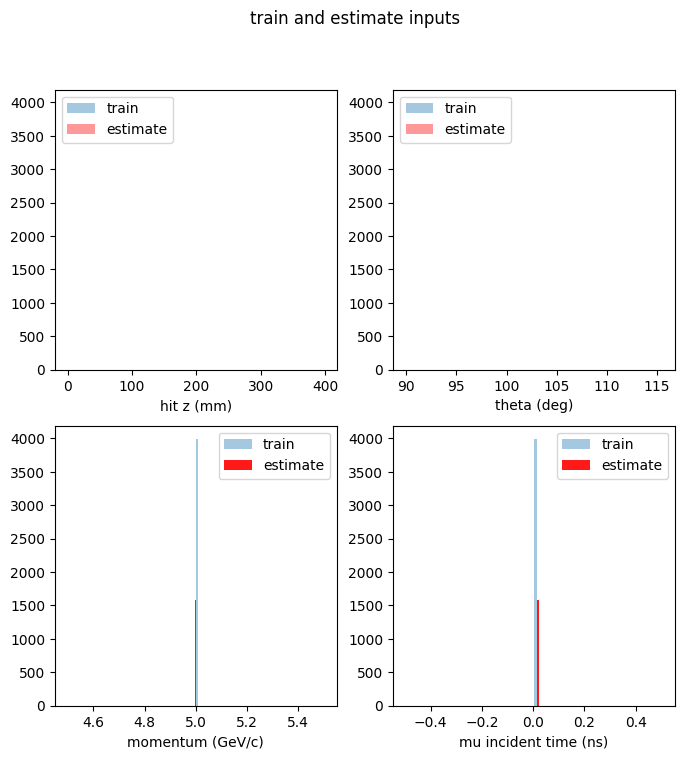

In [18]:
train_fig,train_axs = plot.subplots(2,2,figsize=(8,8))
train_fig.suptitle("train and estimate inputs")
train_axs[0,0].hist(train_inputs[:,0],bins = 100,label="train",alpha = 0.4)
train_axs[0,0].set_xlabel("hit z (mm)")
train_axs[0,1].hist(train_inputs[:,1],bins = 100,label="train",alpha = 0.4)
train_axs[0,1].set_xlabel("theta (deg)")
train_axs[1,0].hist(train_inputs[:,2],bins = 100,label="train",alpha = 0.4)
train_axs[1,0].set_xlabel("momentum (GeV/c)")
train_axs[1,1].hist(train_inputs[:,3],bins = 100,label="train",alpha = 0.4)
train_axs[1,1].set_xlabel("mu incident time (ns)")

train_axs[0,0].hist(estimate_inputs[:,0],bins = 1,color = "red",label="estimate",alpha = 0.4)
train_axs[0,0].set_xlabel("hit z (mm)")
train_axs[0,0].legend()
train_axs[0,1].hist(estimate_inputs[:,1],bins = 1,color = "red",label="estimate",alpha = 0.4)
train_axs[0,1].set_xlabel("theta (deg)")
train_axs[0,1].legend()
train_axs[1,0].hist(estimate_inputs[:,2],bins = 1,color = "red",label="estimate",alpha = 0.9)
train_axs[1,0].set_xlabel("momentum (GeV/c)")
train_axs[1,0].legend()
train_axs[1,1].hist(estimate_inputs[:,3],bins = 1,color = "red",label="estimate",alpha = 0.9)
train_axs[1,1].set_xlabel("mu incident time (ns)")
train_axs[1,1].legend()
train_fig.savefig("plots/compare_train_estimate/august_7_theta_90_pos_0_0_middle_z_calc.pdf")
train_fig.show()

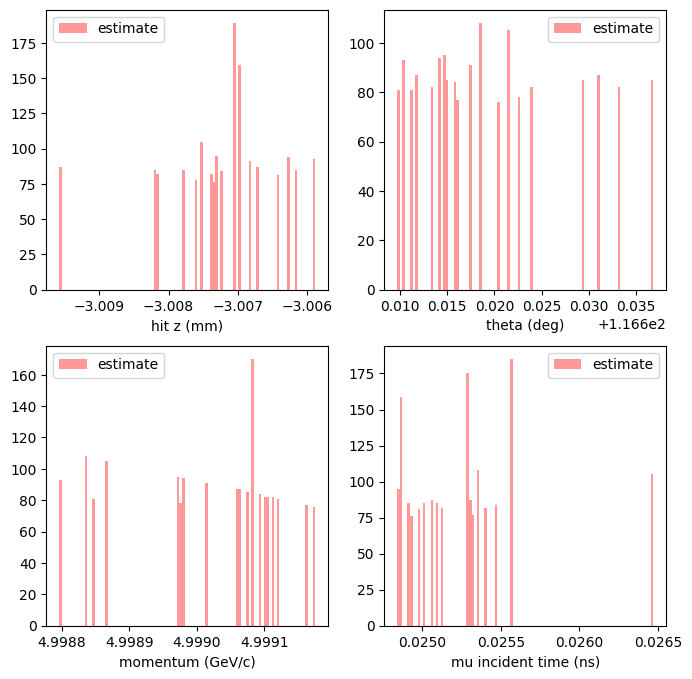

In [62]:
train_fig,train_axs = plot.subplots(2,2,figsize=(8,8))

train_axs[0,0].hist(estimate_inputs[:,0],bins = 100,color = "red",label="estimate",alpha = 0.4)
train_axs[0,0].set_xlabel("hit z (mm)")
train_axs[0,0].legend()
train_axs[0,1].hist(estimate_inputs[:,1],bins = 100,color = "red",label="estimate",alpha = 0.4)
train_axs[0,1].set_xlabel("theta (deg)")
train_axs[0,1].legend()
train_axs[1,0].hist(estimate_inputs[:,2],bins = 100,color = "red",label="estimate",alpha = 0.4)
train_axs[1,0].set_xlabel("momentum (GeV/c)")
train_axs[1,0].legend()
train_axs[1,1].hist(estimate_inputs[:,3],bins = 100,color = "red",label="estimate",alpha = 0.4)
train_axs[1,1].set_xlabel("mu incident time (ns)")
train_axs[1,1].legend()

In [8]:
import torch

In [10]:
a = torch.load(pref + "macros/Timing_estimation/data/August_06/Run_1/Vary_p_events_file_0_July_23_600_z_pos_fixed_z_hit_pos.pt")